# VIX-Adjusted Momentum and SMA (INDIA)

[Previously](https://github.com/stockviz/plutons/blob/master/vix-adjusted-momentum-INDIA.R.md), we saw how a vanilla VIX-adjusted strategy did not lead to excess returns over buy-and-hold. However, during the back-test, a 50-day look-back produces lower drawdowns. This notebook combines the VIX-adjusted momentum and SMA to create a low drawdown strategy that can beat buy-and-hold when levered up using futures.

In [1]:
library(tidyverse)
library(ggthemes)
library(reshape2)
library(odbc)
library(plutoR)
library(quantmod)
library(lubridate)
library(ggrepel)
library(PerformanceAnalytics)

options("scipen"=999)
options(stringsAsFactors = FALSE)
options(repr.plot.width=16, repr.plot.height=8)

source("config.R")
source("goofy/plot.common.R")
source("goofy/misc.common.R")

indices <- Indices()

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.2.0     ✔ purrr   0.3.2
✔ tibble  2.1.3     ✔ dplyr   0.8.1
✔ tidyr   0.8.3     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘reshape2’

The following object is masked from ‘package:tidyr’:

    smiths

Loading required package: xts
Loading required package: zoo

Attaching package: ‘zoo’

The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


Attaching package: ‘xts’

The following objects are masked from ‘package:dplyr’:

    first, last

Loading required package: TTR
Version 0.4-0 included new data defaults. See ?getSymbols.

Attaching package: ‘lubridate’

The following object is masked from ‘package:base’:

    date


Attaching package: ‘PerformanceAnalytics’

The following obje

In [2]:
startDate <- as.Date('2009-03-03') #the day when India VIX was launched
endDate <- as.Date('2019-06-30')

vixDt <- indices$IndiaVixTimeSeries() %>%
    filter(TIME_STAMP >= startDate & TIME_STAMP <= endDate) %>%
    select(TIME_STAMP, CLOSE) %>%
    collect()
    
nifty50Dt <- indices$NseTimeSeries() %>%
    filter(NAME == 'NIFTY 50' & TIME_STAMP >= startDate & TIME_STAMP <= endDate) %>%
    select(TIME_STAMP, CLOSE) %>%
    collect()

In [3]:
doLookback <- function(lb){
    allXts <- merge(xts(nifty50Dt$CLOSE, nifty50Dt$TIME_STAMP), xts(vixDt$CLOSE, vixDt$TIME_STAMP))
    names(allXts) <- c('NIFTY', 'VIX')

    allXts$SMA <- SMA(allXts$NIFTY, lb)
    allXts$D_RET <- dailyReturn(allXts$NIFTY)
    allXts$D_RET_LAG_1 <- stats::lag(allXts$D_RET, -1) #signal is generated and traded at the close, so use next day's return

    allXts$VIX_ADJ_RET <- allXts$D_RET/allXts$VIX
    allXts$VIX_ADJ_RET_SMA <- SMA(allXts$VIX_ADJ_RET, lb) 

    allXts <- na.omit(allXts)

    #go long only if the index is above its lb-day average
    allXts$SMA_STRAT <- ifelse(allXts$NIFTY > allXts$SMA, allXts$D_RET_LAG_1, 0) 

    #go long only if the simple average (VIX-Adjusted Momentum) > 0
    allXts$VIX_STRAT <- ifelse(allXts$VIX_ADJ_RET_SMA > 0, allXts$D_RET_LAG_1, 0) 

    #go long only if both fire
    allXts$COMBO_STRAT <- ifelse(allXts$NIFTY > allXts$SMA & allXts$VIX_ADJ_RET_SMA > 0, allXts$D_RET_LAG_1, 0)

    #plot returns
    toPlot <- merge(allXts$COMBO_STRAT, allXts$VIX_STRAT, allXts$SMA_STRAT, allXts$D_RET_LAG_1)
    Common.PlotCumReturns(toPlot, sprintf("Back-test for %d look-back", lb), "")
    
    #print drawdowns
    print("VIX + SMA Drawdowns")
    print(table.Drawdowns(allXts$COMBO_STRAT, 10))
    
    print("VIX Only Drawdowns")
    print(table.Drawdowns(allXts$VIX_STRAT, 10))
    
    print("SMA Only Drawdowns")
    print(table.Drawdowns(allXts$SMA_STRAT, 10))
    
    print("Buy & Hold Drawdowns")
    print(table.Drawdowns(allXts$D_RET_LAG_1, 10))

    #calculate annual returns

    byYearDf <- data.frame(T=0, COMBO=0.0, VIX_MOM=0.0, SMA=0.0, BH=0.0)

    allYears <- unique(year(index(allXts)))
    for(yr in allYears){
        byYearDf <- rbind(byYearDf,
                        c(yr, as.numeric(100.0*Return.cumulative(allXts[toString(yr), 'COMBO_STRAT'])),
                            as.numeric(100.0*Return.cumulative(allXts[toString(yr), 'VIX_STRAT'])),
                            as.numeric(100.0*Return.cumulative(allXts[toString(yr), 'SMA_STRAT'])),
                            as.numeric(100.0*Return.cumulative(allXts[toString(yr), 'D_RET_LAG_1']))))
    }

    byYearDf <- byYearDf[-1,]
    print(byYearDf)

    #plot annual returns

    ggplot(melt(byYearDf, id='T'), aes(x=T, y=value, fill=variable)) +
        theme_economist() +
        geom_bar(stat="identity", position=position_dodge()) +
        scale_x_continuous(labels=byYearDf$T, breaks=byYearDf$T) +
        geom_text_repel(aes(label= round(value, 2)), position = position_dodge(0.9)) +
        labs(x='', y='(%)', fill='', title=sprintf("Back-test for %d look-back", lb), subtitle="Annual Returns") +
        annotate("text", x=max(byYearDf$T), y=min(sapply(byYearDf[,-1], min, na.rm=T)), 
                 label = "@StockViz", hjust=1.1, vjust=-1.1, col="white", cex=6, fontface = "bold", alpha = 0.8)  
}    

[1] "VIX + SMA Drawdowns"
         From     Trough         To   Depth Length To Trough Recovery
1  2010-11-05 2014-01-24 2014-06-05 -0.1831    893       805       88
2  2009-06-10 2009-08-18 2010-09-13 -0.1340    315        50      265
3  2014-11-28 2016-04-06 2016-08-05 -0.1310    419       336       83
4  2018-01-29 2018-05-22 2018-08-17 -0.0795    139        77       62
5  2016-09-08 2017-01-19 2017-03-10 -0.0681    126        92       34
6  2018-08-28 2019-02-26 2019-04-15 -0.0675    156       124       32
7  2017-08-01 2017-12-12 2018-01-18 -0.0528    118        92       26
8  2014-09-08 2014-10-23 2014-11-14 -0.0520     43        30       13
9  2019-04-16 2019-05-22       <NA> -0.0502     49        23       NA
10 2014-07-07 2014-07-11 2014-07-22 -0.0428     12         5        7
[1] "VIX Only Drawdowns"
         From     Trough         To   Depth Length To Trough Recovery
1  2010-11-05 2011-12-09 2014-07-23 -0.2854    927       271      656
2  2009-06-10 2009-07-10 2009-07-31 -0.

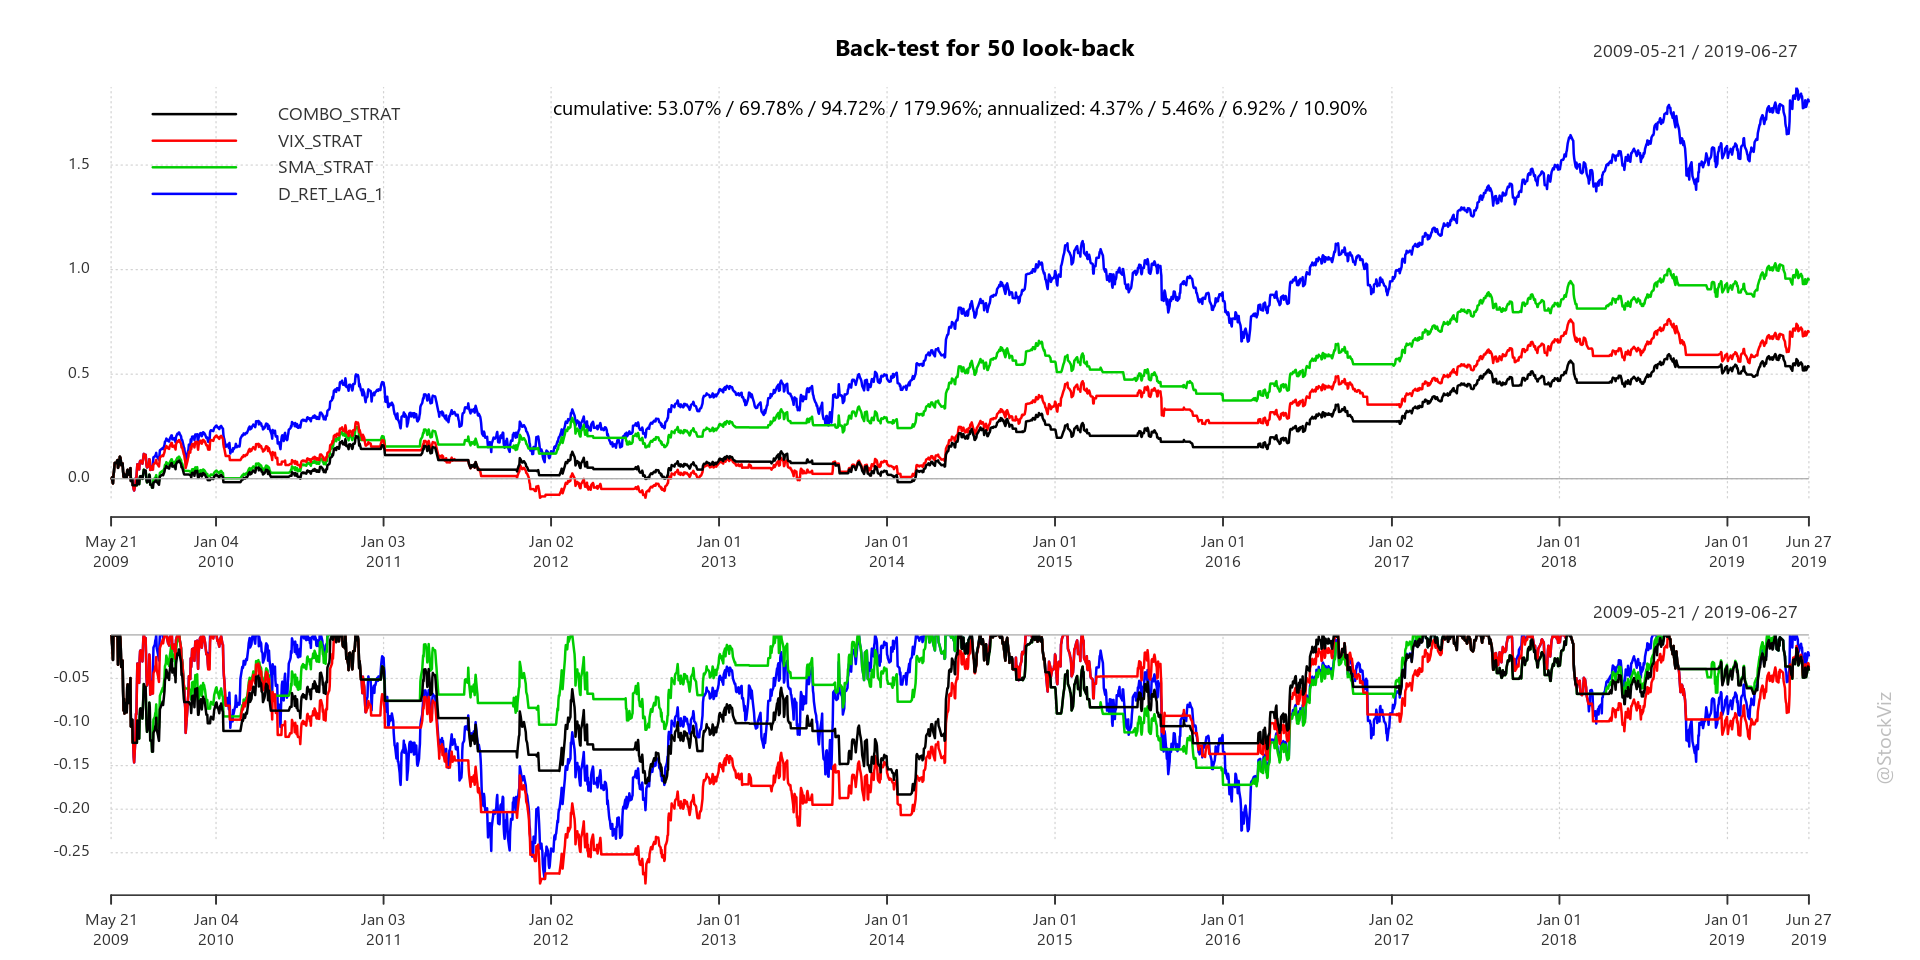

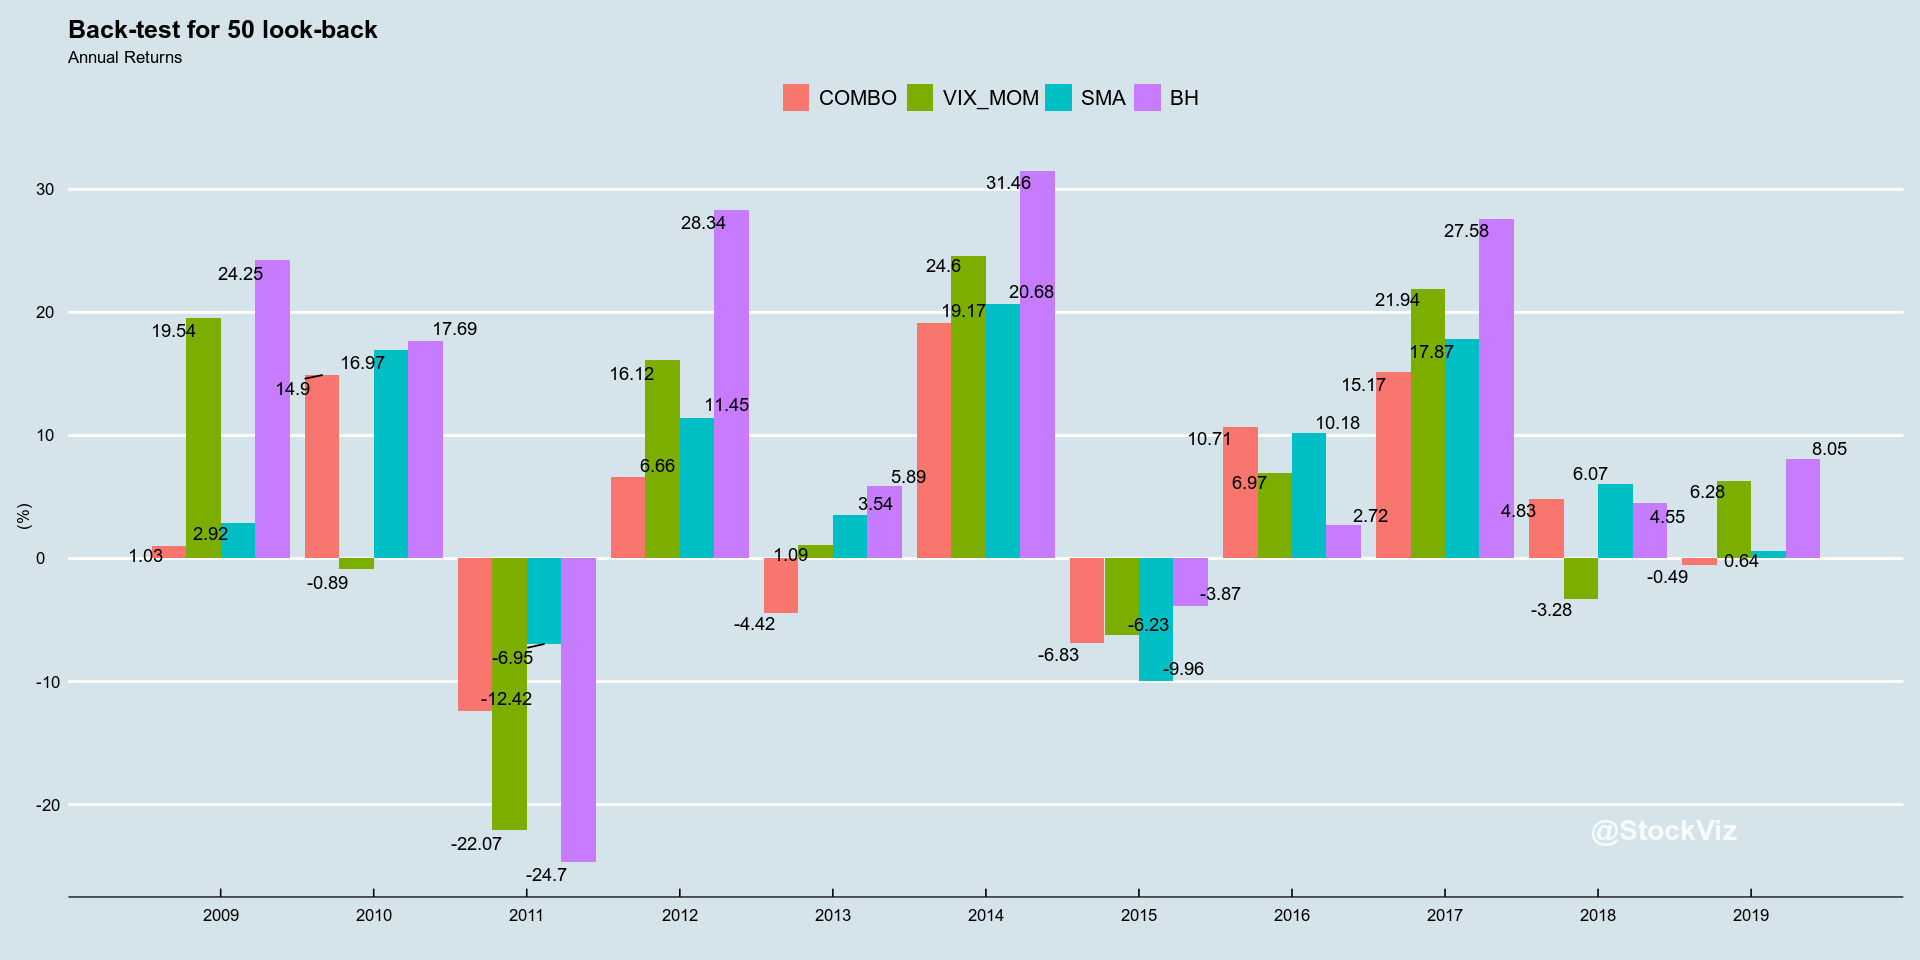

In [4]:
doLookback(50)

This was a tad disappointing. The combined signal had a worse drawdown and return profile than plain-vanilla SMA(50). The tricky bit is the 2009 through 2014 time-frame where side-ways market would have destoryed any trend following strategy.

This notebook was created using [pluto](http://pluto.studio). Learn more [here](https://github.com/shyams80/pluto)